In [1]:
import torch

import torch.nn as nn

#from nvae.utils import add_sn
#from nvae.vae_celeba import NVAE
import numpy as np
import matplotlib.pyplot as plt
#from nvae.utils import reparameterize


In [2]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

from vae import VAE_big

model = VAE_big(device, image_channels=3).to(device)

train_data_size = 162079
epochs = 199

model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
model.eval()

VAE_big(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2))
    (13): ReLU()
    (14): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 256, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kern

In [3]:
desired_norm_l2 = 6.666609  # Change this to your desired constant value
desired_norm_l_inf = 0.9  # Change this to your desired constant value


noise_addition = (2.0 * torch.rand(1, 3, 64, 64).to(device) - 1.0) 

current_L_2_norm = torch.norm(noise_addition, 2)
current_L_inf_norm = torch.norm(noise_addition, p=float('inf'))

print("current_L_2_norm", current_L_2_norm)
print("current_L_inf_norm", current_L_inf_norm)


scaled_noise = noise_addition * (desired_norm_l2 / current_L_2_norm) *  (desired_norm_l_inf / current_L_inf_norm)


final_l2_norm = torch.norm(scaled_noise, 2)

print("final_l2_norm", final_l2_norm)

l_inf_norm_after_scaling = torch.norm(scaled_noise, p=float('inf'))

print("l_inf_norm_after_scaling", l_inf_norm_after_scaling)


# target l2 - 6.0, target l_inf - 0.094


current_L_2_norm tensor(64.1068, device='cuda:0')
current_L_inf_norm tensor(0.9999, device='cuda:0')
final_l2_norm tensor(6.0004, device='cuda:0')
l_inf_norm_after_scaling tensor(0.0936, device='cuda:0')


In [4]:
noise_addition.max(), noise_addition.min()

(tensor(0.9998, device='cuda:0'), tensor(-0.9999, device='cuda:0'))

In [5]:
scaled_noise.max(), scaled_noise.min()

(tensor(0.0936, device='cuda:0'), tensor(-0.0936, device='cuda:0'))

In [6]:
#from torch.utils.data import DataLoader
#from nvae.dataset import ImageFolderDataset

#dataset_path = '/home/luser/exploring_gans/celebA/img_align_celeba'

In [7]:
#train_ds = ImageFolderDataset(dataset_path, img_dim=64)
#train_dataloader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=16)

# VAE plots

Young men selected segment 29

Od men selecte segment 0

Young women segment 5

Old women segment 15

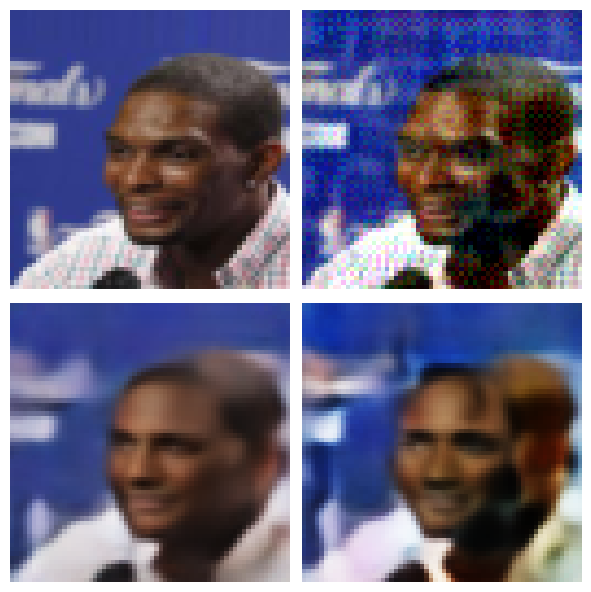

DivOutputL2ActualOutput tensor(0.0621, device='cuda:0', grad_fn=<SqueezeBackward0>)
instability tensor(0.8072, device='cuda:0', grad_fn=<DivBackward0>)


In [12]:
segment = 0
# 0
desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

#all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = universal_features_list[1]

methods = ["lip", "div", "log_lip", "log_div"]
method = methods[2]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/n_obj_"+method+"_feature_"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt").to(device) 



image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())

input_change = torch.sqrt((source_im - NormalDivAttackeImage)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

instability = DivOutputL2ActualOutput/input_change

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(6, 6/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()


print("DivOutputL2ActualOutput", DivOutputL2ActualOutput)

print("instability", instability)


In [9]:
device

'cuda:0'

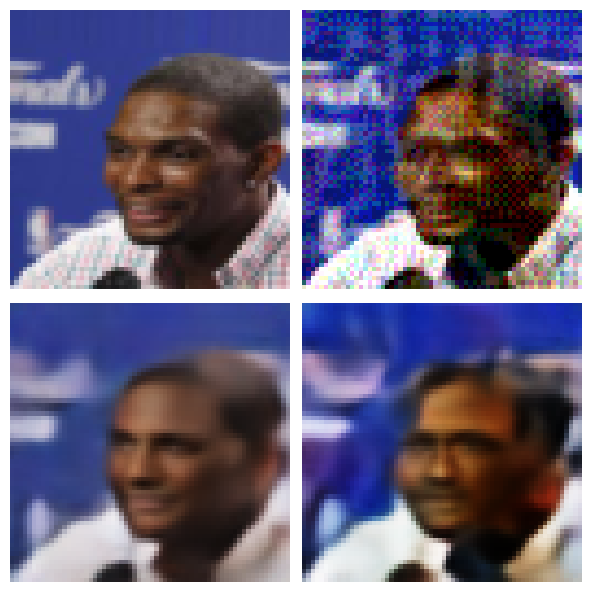

DivOutputL2ActualOutput tensor(0.0740, device='cuda:0', grad_fn=<SqueezeBackward0>)
instability tensor(0.7095, device='cuda:0', grad_fn=<DivBackward0>)


In [13]:
segment = 0
# 0
desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

#all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = universal_features_list[1]

methods = ["lip", "div", "log_lip", "log_div"]
method = methods[3]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/n_obj_"+method+"_feature_"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location = device).to(device) 



image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())

input_change = torch.sqrt((source_im - NormalDivAttackeImage)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

instability = DivOutputL2ActualOutput/input_change


model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(6, 6/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()


print("DivOutputL2ActualOutput", DivOutputL2ActualOutput)

print("instability", instability)

# Beta VAE plots

In [16]:
#segment = 29
# 6, 10
#desired_norm_l_inf = 0.094
beta_value = 5.0

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

#universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

#all_features = [ "men", "women", "blackWomen", "old", "youngmen", "oldmen", "youngwomen", "oldwomen"]
#all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt").to(device) 



image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: '/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/beard_d/beardbeta5.0_scaled_noise_0.094segment0.pt'

In [15]:
ActualReconLoss, DivOutputL2ActualOutput

(tensor(0.0408, device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor(0.0740, device='cuda:0', grad_fn=<SqueezeBackward0>))

## Plot of Gender Race combinations : No definite cardinality plots


In [18]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


'''all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
incl_all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]'''

all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []


youngmen_instability = []
oldmen_instability = []
youngwomen_instability = []
oldwomen_instability = []


for feature_outside, feature_inside in zip(incl_all_features, all_features):
    print(feature_outside, feature_inside)
    for segment in range(61):

        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

        model.eval()

        actualOutput, _, _ = model(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        if feature_outside == "bald":
            bald_instability.append(DivOutputL2ActualOutput.item()) 
        elif feature_outside == "beard":
            beard_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldfemaleGlass":
            femaleGlass_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "hat":
            hat_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackWomen":
            blackwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteWomen":
            whitewomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackMen":
            blackMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteMen":
            whiteMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "men":
            men_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "women":
            women_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "young":
            young_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "old":
            old_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngmen":
            youngmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldmen":
            oldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwomen":
            youngwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwomen":
            oldwomen_instability.append(DivOutputL2ActualOutput.item())


generalWhiteWomen generalWhiteWomen
blackWomen blackWomen
generalWhiteMen generalWhiteMen
blackMen blackMen


In [19]:
len(bald_instability), len(beard_instability), len(femaleGlass_instability), len(hat_instability), len(blackwomen_instability), len(whitewomen_instability), len(blackMen_instability), len(whiteMen_instability), len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)

(0, 0, 0, 0, 61, 61, 61, 61, 0, 0, 0, 0)

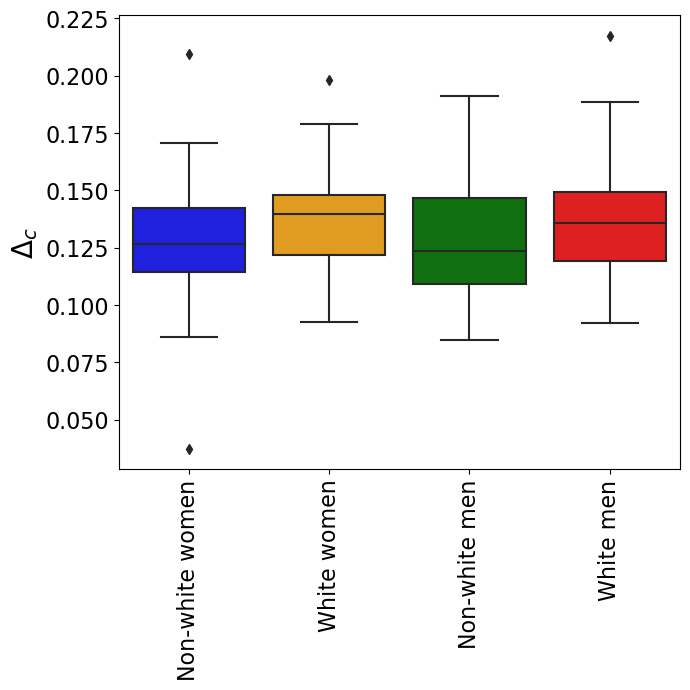

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Non-white women": blackwomen_instability,
    "White women": whitewomen_instability,
    "Non-white men": blackMen_instability,
    "White men": whiteMen_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' , 'green', 'red']
plt.figure(figsize=(7, 7))  # Adjust the width and height as needed

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation='vertical')  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


## Plot of Gender Age combinations

In [22]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
incl_all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]'''

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []


youngmen_instability = []
oldmen_instability = []
youngwomen_instability = []
oldwomen_instability = []


for feature_outside, feature_inside in zip(incl_all_features, all_features):
    print(feature_outside, feature_inside)
    for segment in range(60):

        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

        model.eval()

        actualOutput, _, _ = model(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        if feature_outside == "bald":
            bald_instability.append(DivOutputL2ActualOutput.item()) 
        elif feature_outside == "beard":
            beard_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldfemaleGlass":
            femaleGlass_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "hat":
            hat_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackWomen":
            blackwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteWomen":
            whitewomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackMen":
            blackMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteMen":
            whiteMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "men":
            men_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "women":
            women_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "young":
            young_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "old":
            old_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngmen":
            youngmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldmen":
            oldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwomen":
            youngwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwomen":
            oldwomen_instability.append(DivOutputL2ActualOutput.item())


youngmen youngmen
oldmen oldmen
youngwomen youngwomen
oldwomen oldwomen


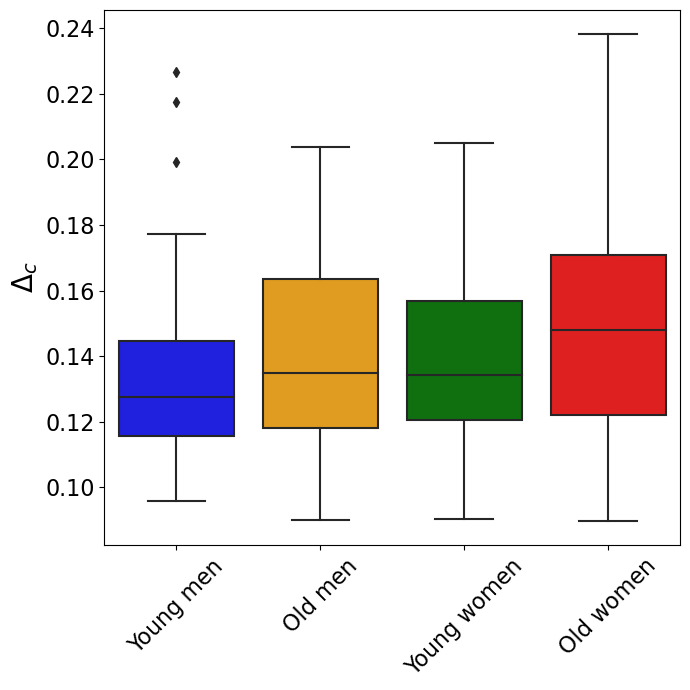

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Young men": youngmen_instability,
    "Old men": oldmen_instability,
    "Young women": youngwomen_instability,
    "Old women": oldwomen_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' , 'green', 'red']
plt.figure(figsize=(7, 7))  # Adjust the width and height as needed

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


#len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)

In [24]:
len(youngmen_instability + youngwomen_instability)

120

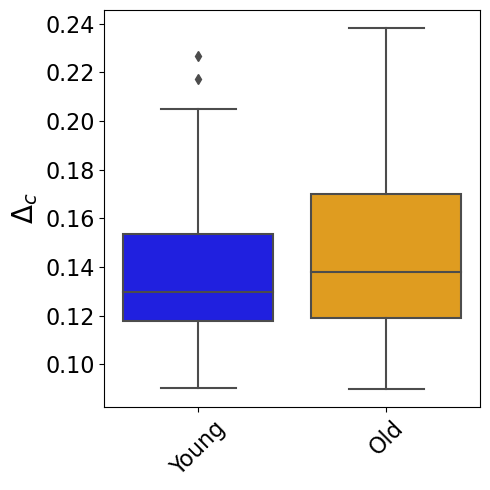

In [25]:
# combine and plot for age

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

young_instability = youngmen_instability + youngwomen_instability
old_instability = oldmen_instability + oldwomen_instability

data = pd.DataFrame({
    "Young": young_instability,
    "Old": old_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' , 'green', 'red']
plt.figure(figsize=(5, 5))  # Adjust the width and height as needed

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


#len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)


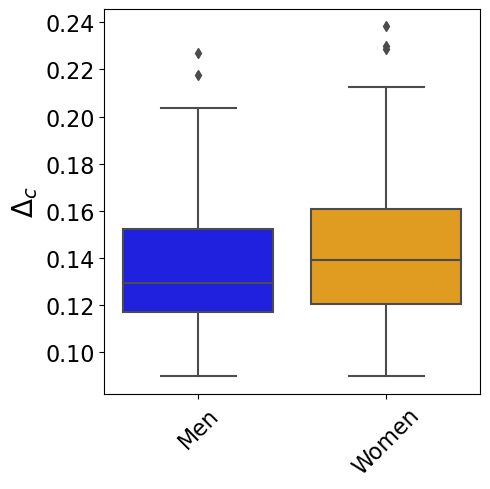

In [26]:
# combine and plot for gender

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

men_instability = youngmen_instability +  oldmen_instability
women_instability = youngwomen_instability + oldwomen_instability

data = pd.DataFrame({
    "Men": men_instability,
    "Women": women_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' , 'green', 'red']
plt.figure(figsize=(5, 5))  # Adjust the width and height as needed

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


#len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)


/tmp/ipykernel_197982/2504941109.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent cutoff of labels


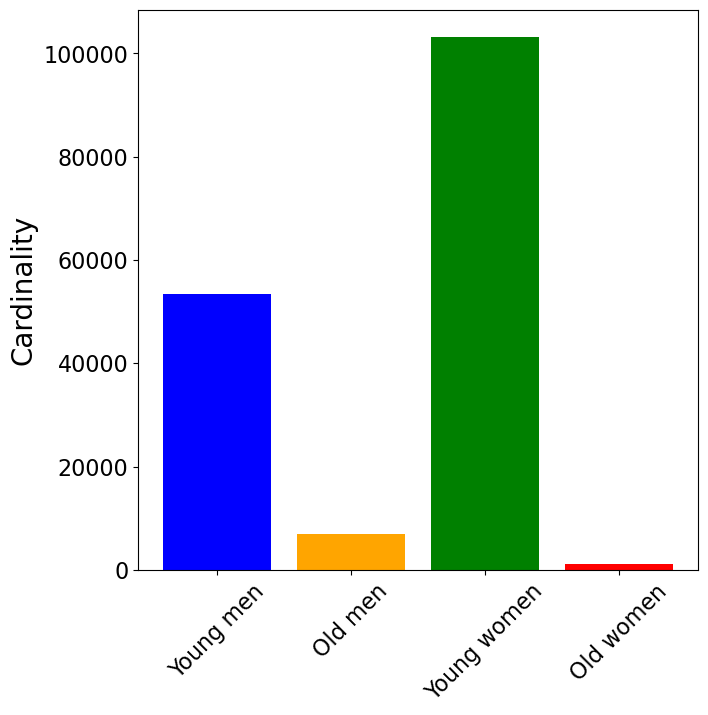

In [27]:
import matplotlib.pyplot as plt

all_features = ["Young men", "Old men", "Young women", "Old women"]
gender_age_combinations_population = [53448, 7003, 103287, 1116]


colors = ['blue', 'orange', 'green', 'red']



fig = plt.figure(figsize=(7, 7))  # Set the figure size

# Create axes with wider margins
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot the bars with specified colors
ax.bar(all_features, gender_age_combinations_population, color=colors)

# Set font sizes
ax.set_ylabel('Cardinality', fontsize=20)  # Adjust the fontsize as needed
#ax.set_xlabel('Feature', fontsize=14)  # Adjust the fontsize as needed
# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/nvae/a_quality_image_saves/cardinalities.png", bbox_inches='tight')  # Use bbox_inches='tight' to include all contents
plt.show()


# Plot of Genders

In [30]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


all_features = ["men", "women"] #, "youngwomen", "oldwomen"]
incl_all_features = ["men", "women"]#, "youngwomen", "oldwomen"]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]'''

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []


youngmen_instability = []
oldmen_instability = []
youngwomen_instability = []
oldwomen_instability = []


for feature_outside, feature_inside in zip(incl_all_features, all_features):
    print(feature_outside, feature_inside)
    for segment in range(61):

        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

        model.eval()

        actualOutput, _, _ = model(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        if feature_outside == "bald":
            bald_instability.append(DivOutputL2ActualOutput.item()) 
        elif feature_outside == "beard":
            beard_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldfemaleGlass":
            femaleGlass_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "hat":
            hat_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackWomen":
            blackwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteWomen":
            whitewomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackMen":
            blackMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteMen":
            whiteMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "men":
            men_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "women":
            women_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "young":
            young_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "old":
            old_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngmen":
            youngmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldmen":
            oldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwomen":
            youngwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwomen":
            oldwomen_instability.append(DivOutputL2ActualOutput.item())


men men
women women


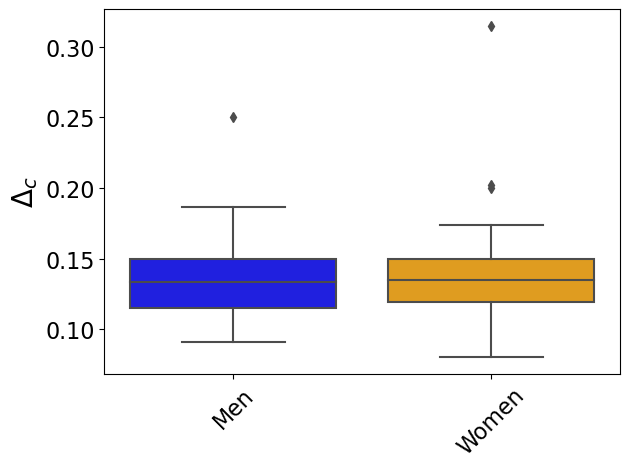

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Men": men_instability,
    "Women": women_instability
})



colors = ['blue', 'orange' ]

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


#len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)

/tmp/ipykernel_197982/2987083540.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent cutoff of labels


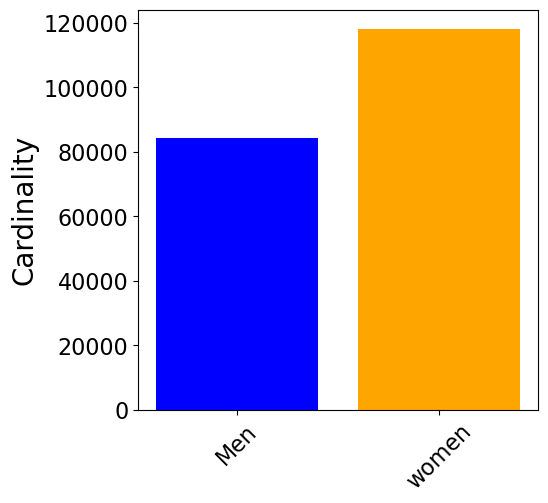

In [32]:
import matplotlib.pyplot as plt

all_features = ["Men", "women"]
gender_age_combinations_population = [84434, 118165]



colors = ['blue', 'orange']#, 'green', 'red']



fig = plt.figure(figsize=(5, 5))  # Set the figure size

# Create axes with wider margins
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot the bars with specified colors
ax.bar(all_features, gender_age_combinations_population, color=colors)

# Set font sizes
ax.set_ylabel('Cardinality', fontsize=20)  # Adjust the fontsize as needed
#ax.set_xlabel('Feature', fontsize=14)  # Adjust the fontsize as needed
# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/nvae/a_quality_image_saves/cardinalities.png", bbox_inches='tight')  # Use bbox_inches='tight' to include all contents
plt.show()


# Plot of Age

In [35]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


all_features = ["young", "old"] #, "youngwomen", "oldwomen"]
incl_all_features = ["young", "old"]#, "youngwomen", "oldwomen"]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]'''

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []


youngmen_instability = []
oldmen_instability = []
youngwomen_instability = []
oldwomen_instability = []


for feature_outside, feature_inside in zip(incl_all_features, all_features):
    print(feature_outside, feature_inside)
    for segment in range(20):

        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

        model.eval()

        actualOutput, _, _ = model(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        if feature_outside == "bald":
            bald_instability.append(DivOutputL2ActualOutput.item()) 
        elif feature_outside == "beard":
            beard_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldfemaleGlass":
            femaleGlass_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "hat":
            hat_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackWomen":
            blackwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteWomen":
            whitewomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackMen":
            blackMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteMen":
            whiteMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "men":
            men_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "women":
            women_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "young":
            young_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "old":
            old_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngmen":
            youngmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldmen":
            oldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwomen":
            youngwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwomen":
            oldwomen_instability.append(DivOutputL2ActualOutput.item())


young young
old old


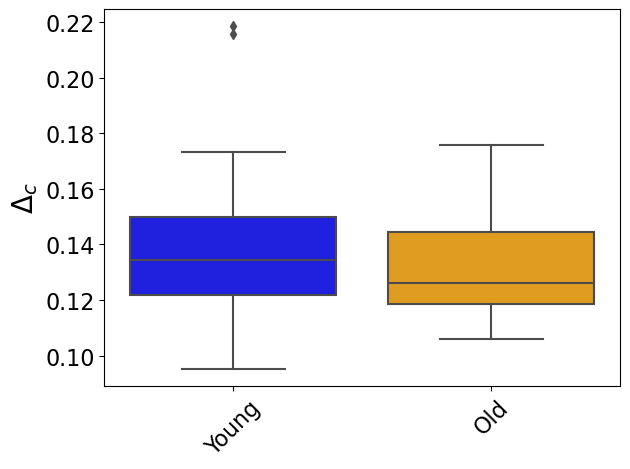

In [36]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Young": young_instability,
    "Old": old_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' ]#, 'green', 'red']

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


/tmp/ipykernel_197982/2448261367.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent cutoff of labels


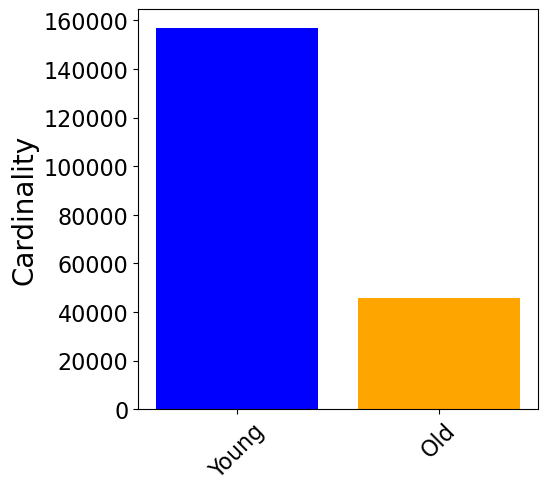

In [37]:
import matplotlib.pyplot as plt

all_features = ["Young", "Old"]
age_population = [156734, 45865]



colors = ['blue', 'orange']#, 'green', 'red']



fig = plt.figure(figsize=(5, 5))  # Set the figure size

# Create axes with wider margins
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot the bars with specified colors
ax.bar(all_features, age_population, color=colors)

# Set font sizes
ax.set_ylabel('Cardinality', fontsize=20)  # Adjust the fontsize as needed
#ax.set_xlabel('Feature', fontsize=14)  # Adjust the fontsize as needed
# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/nvae/a_quality_image_saves/cardinalities.png", bbox_inches='tight')  # Use bbox_inches='tight' to include all contents
plt.show()


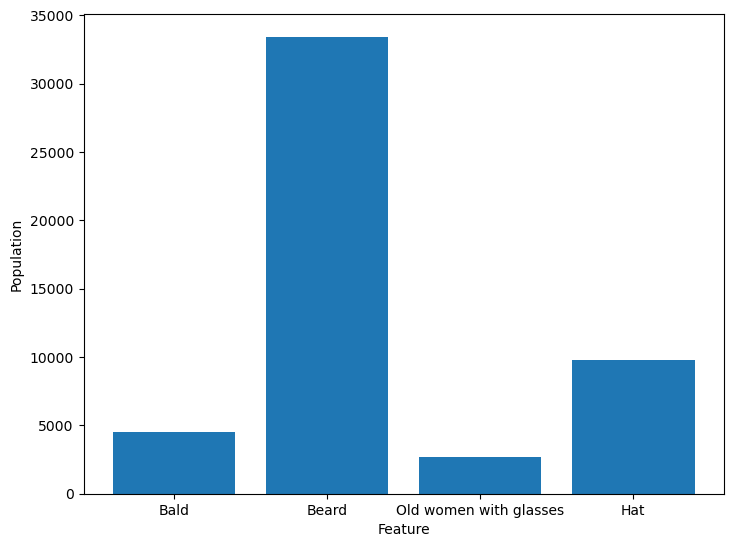

In [38]:
# plot a bar chart of corresponding_class_polulations

import matplotlib.pyplot as plt

all_features = ["Bald", "Beard", "Old women with glasses", "Hat"]


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(all_features, corresponding_class_polulations)
ax.set_ylabel('Population')
ax.set_xlabel('Feature')
plt.show()


## Plot of Gender Race and age combinations : No definite cardinality plots (Vanilla VAE)


In [40]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen", "oldblackmen", "oldblackwomen", "oldwhitemen", "oldwhitewomen", "youndblackmen", "youndblackwomen", "youngwhitemen", "youngwhitewomen" ]


'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


all_features = ["oldblackmen", "oldblackwomen", "oldwhitemen", "oldwhitewomen", "youndblackmen", "youndblackwomen", "youngwhitemen", "youngwhitewomen" ] #, "youngwomen", "oldwomen"]
incl_all_features = ["oldblackmen", "oldblackwomen", "oldwhitemen", "oldwhitewomen", "youndblackmen", "youndblackwomen", "youngwhitemen", "youngwhitewomen" ]#, "youngwomen", "oldwomen"]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]'''

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []


youngmen_instability = []
oldmen_instability = []
youngwomen_instability = []
oldwomen_instability = []


blackyoungmen_instability = []
whiteyoungmen_instability = []
blackoldmen_instability = []
whiteoldmen_instability = []
blackyoungwomen_instability = []
whiteyoungwomen_instability = []
blackoldwomen_instability = []
whiteoldwomen_instability = []

for feature_outside, feature_inside in zip(incl_all_features, all_features):
    print(feature_outside, feature_inside)
    for segment in range(20):

        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

        model.eval()

        actualOutput, _, _ = model(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        if feature_outside == "bald":
            bald_instability.append(DivOutputL2ActualOutput.item()) 
        elif feature_outside == "beard":
            beard_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldfemaleGlass":
            femaleGlass_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "hat":
            hat_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackWomen":
            blackwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteWomen":
            whitewomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackMen":
            blackMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteMen":
            whiteMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "men":
            men_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "women":
            women_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "young":
            young_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "old":
            old_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngmen":
            youngmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldmen":
            oldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwomen":
            youngwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwomen":
            oldwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldblackmen":
            blackoldmen_instability .append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldblackwomen":
            blackoldwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwhitemen":
            whiteoldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwhitewomen":
            whiteoldwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youndblackmen":
            blackyoungmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youndblackwomen":
            blackyoungwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwhitemen":
            whiteyoungmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwhitewomen":
            whiteyoungwomen_instability.append(DivOutputL2ActualOutput.item())



oldblackmen oldblackmen
oldblackwomen oldblackwomen
oldwhitemen oldwhitemen
oldwhitewomen oldwhitewomen
youndblackmen youndblackmen
youndblackwomen youndblackwomen
youngwhitemen youngwhitemen
youngwhitewomen youngwhitewomen


In [41]:
len(blackoldmen_instability), len(blackoldwomen_instability), len(whiteoldmen_instability), len(whiteoldwomen_instability), len(blackyoungmen_instability), len(blackyoungwomen_instability), len(whiteyoungmen_instability), len(whiteyoungwomen_instability)

(20, 20, 20, 20, 20, 20, 20, 20)

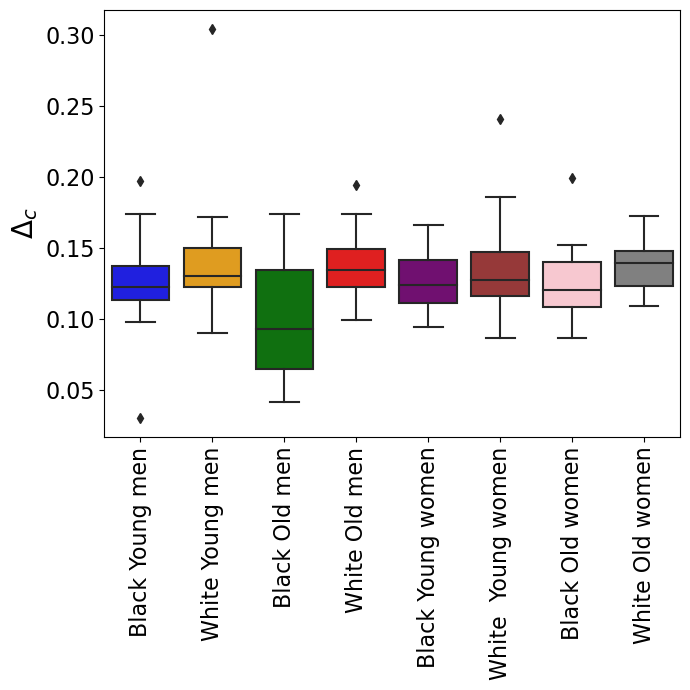

In [42]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Black Young men": blackyoungmen_instability,
    "White Young men": whiteyoungmen_instability,
    "Black Old men": blackoldmen_instability,
    "White Old men": whiteoldmen_instability,
    "Black Young women": blackyoungwomen_instability,
    "White  Young women": whiteyoungwomen_instability,
    "Black Old women": blackoldwomen_instability,
    "White Old women": whiteoldwomen_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' , 'green', 'red', 'purple', 'brown', 'pink', 'gray']
plt.figure(figsize=(7, 7))  # Adjust the width and height as needed

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation='vertical')  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


#len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)

# Gender age combinations beta 5

In [44]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
beta_value = 5.0
#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
incl_all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]'''

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []


youngmen_instability = []
oldmen_instability = []
youngwomen_instability = []
oldwomen_instability = []


for feature_outside, feature_inside in zip(incl_all_features, all_features):
    print(feature_outside, feature_inside)
    for segment in range(60):

        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

        model.eval()

        actualOutput, _, _ = model(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        if feature_outside == "bald":
            bald_instability.append(DivOutputL2ActualOutput.item()) 
        elif feature_outside == "beard":
            beard_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldfemaleGlass":
            femaleGlass_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "hat":
            hat_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackWomen":
            blackwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteWomen":
            whitewomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackMen":
            blackMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteMen":
            whiteMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "men":
            men_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "women":
            women_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "young":
            young_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "old":
            old_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngmen":
            youngmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldmen":
            oldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwomen":
            youngwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwomen":
            oldwomen_instability.append(DivOutputL2ActualOutput.item())


youngmen youngmen
oldmen oldmen
youngwomen youngwomen
oldwomen oldwomen


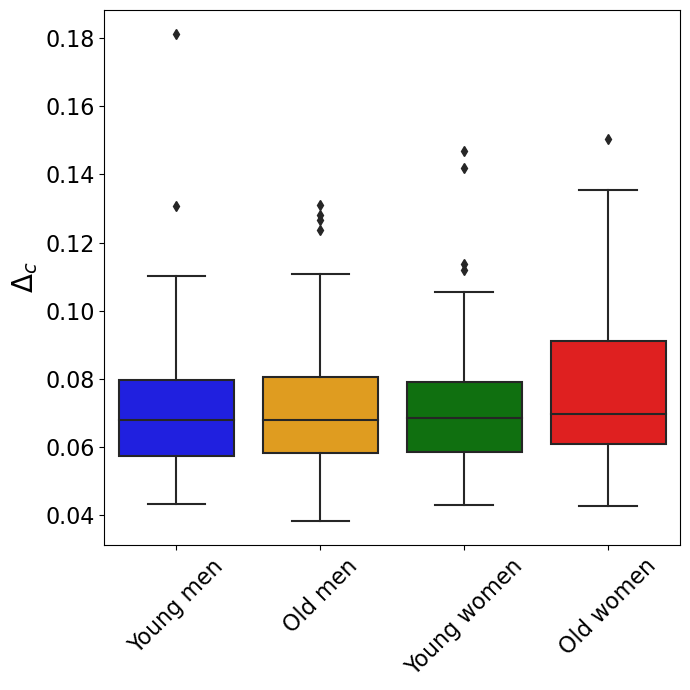

In [45]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Young men": youngmen_instability,
    "Old men": oldmen_instability,
    "Young women": youngwomen_instability,
    "Old women": oldwomen_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' , 'green', 'red']
plt.figure(figsize=(7, 7))  # Adjust the width and height as needed

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


#len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)

In [47]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
beta_value = 10.0
#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
incl_all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]'''

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []


youngmen_instability = []
oldmen_instability = []
youngwomen_instability = []
oldwomen_instability = []


for feature_outside, feature_inside in zip(incl_all_features, all_features):
    print(feature_outside, feature_inside)
    for segment in range(20):

        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

        model.eval()

        actualOutput, _, _ = model(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        if feature_outside == "bald":
            bald_instability.append(DivOutputL2ActualOutput.item()) 
        elif feature_outside == "beard":
            beard_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldfemaleGlass":
            femaleGlass_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "hat":
            hat_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackWomen":
            blackwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteWomen":
            whitewomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "blackMen":
            blackMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "generalWhiteMen":
            whiteMen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "men":
            men_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "women":
            women_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "young":
            young_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "old":
            old_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngmen":
            youngmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldmen":
            oldmen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "youngwomen":
            youngwomen_instability.append(DivOutputL2ActualOutput.item())
        elif feature_outside == "oldwomen":
            oldwomen_instability.append(DivOutputL2ActualOutput.item())


youngmen youngmen
oldmen oldmen
youngwomen youngwomen
oldwomen oldwomen


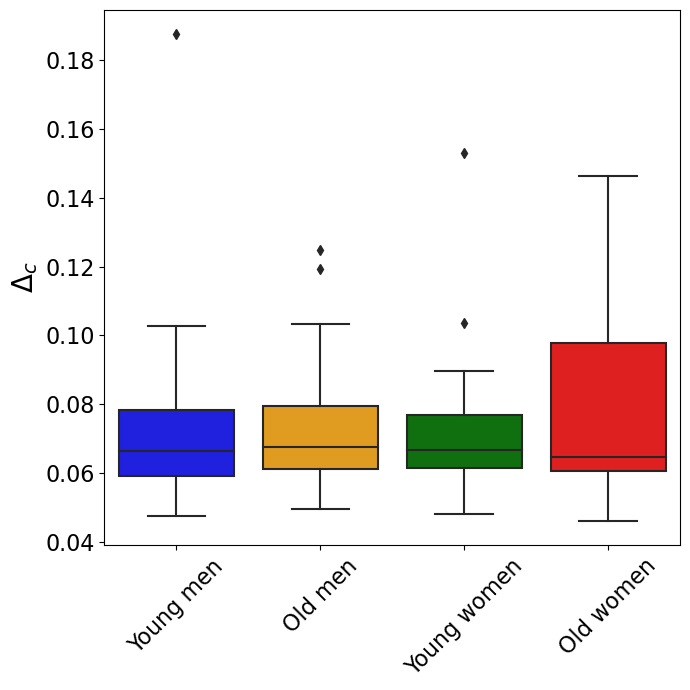

In [48]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Young men": youngmen_instability,
    "Old men": oldmen_instability,
    "Young women": youngwomen_instability,
    "Old women": oldwomen_instability
})

# Define colors for the boxplots
colors = ['blue', 'orange' , 'green', 'red']
plt.figure(figsize=(7, 7))  # Adjust the width and height as needed

sns.boxplot(data=data, palette=colors)
#plt.xlabel("Feature", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel(r"$\Delta_c$", fontsize=20)  # Using LaTeX formatting for the ylabel

# Increase font size of xticks and yticks
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/deviations_Beta_VAE_Beta1_rho_pt094_n_20.png")
plt.show()


#len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)

# Scatter plot 

In [51]:
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,]

#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#segment = 2
#all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

desired_norm_l_inf = 0.094
beta_value = 1.0

all_beta_values = [1.0, 5.0]

#desired_norm_l_inf = 0.05
#all_features = ["bald", "beard", "femaleGlass", "hat", "bald", "generalWhiteWomen"]

#incl_all_features = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen" ]

#all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

#incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen", "men", "women", "young", "old"]'''


all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
incl_all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]

'''all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]
incl_all_features = ["generalWhiteWomen", "blackWomen", "generalWhiteMen", "blackMen"]'''

#all_features = ["generalWhiteMen", "blackMen"]
#incl_all_features = ["generalWhiteMen", "blackMen"]

#all_features = ["generalWhiteWomen", "blackWomen"]


corresponding_class_polulations = [4547, 33441, 2715, 9818]

bald_instability = []
beard_instability = []
femaleGlass_instability = []
hat_instability = []
blackwomen_instability = []
whitewomen_instability = []
blackMen_instability = []
whiteMen_instability = []
men_instability = []
women_instability = []
young_instability = []
old_instability = []





for beta_value in all_beta_values:
    youngmen_instability = []
    youngmen_recon_loss = []

    oldmen_instability = []
    oldmen_reconloss = []

    youngwomen_instability = []
    youngwomen_recon_loss = []

    oldwomen_instability = []
    oldwomen_recon_loss = []

    for feature_outside, feature_inside in zip(incl_all_features, all_features):
        print(feature_outside, feature_inside)
        for segment in range(60):

            source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_inside)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
            #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_noise_"+str(distort_valuae)+"segment"+str(segment)+".pt").to(device)
            if(beta_value == 5.0 or beta_value == 10.0): 
                optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
            else:
                optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature_outside)+"_d/"+str(feature_inside)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

            model.eval()

            actualOutput, _, _ = model(source_im)
            ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

            DivAttackeImage = source_im + optimized_noise
            NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
            DivOutput,_,_ = model(NormalDivAttackeImage)
            DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

            if feature_outside == "bald":
                bald_instability.append(DivOutputL2ActualOutput.item()) 
            elif feature_outside == "beard":
                beard_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "oldfemaleGlass":
                femaleGlass_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "hat":
                hat_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "blackWomen":
                blackwomen_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "generalWhiteWomen":
                whitewomen_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "blackMen":
                blackMen_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "generalWhiteMen":
                whiteMen_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "men":
                men_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "women":
                women_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "young":
                young_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "old":
                old_instability.append(DivOutputL2ActualOutput.item())
            elif feature_outside == "youngmen":
                youngmen_instability.append(DivOutputL2ActualOutput.item())
                youngmen_recon_loss.append(ActualReconLoss.item())
            elif feature_outside == "oldmen":
                oldmen_instability.append(DivOutputL2ActualOutput.item())
                oldmen_reconloss.append(ActualReconLoss.item())
            elif feature_outside == "youngwomen":
                youngwomen_instability.append(DivOutputL2ActualOutput.item())
                youngwomen_recon_loss.append(ActualReconLoss.item())
            elif feature_outside == "oldwomen":
                oldwomen_instability.append(DivOutputL2ActualOutput.item())
                oldwomen_recon_loss.append(ActualReconLoss.item())

    if(beta_value == 1.0):
        beta1_deviations = youngmen_instability + oldmen_instability + youngwomen_instability + oldwomen_instability
        beta1_recon_loss = youngmen_recon_loss + oldmen_reconloss + youngwomen_recon_loss + oldwomen_recon_loss
    if(beta_value == 5.0):
        beta2_deviations = youngmen_instability + oldmen_instability + youngwomen_instability + oldwomen_instability
        beta2_recon_loss = youngmen_recon_loss + oldmen_reconloss + youngwomen_recon_loss + oldwomen_recon_loss

    if(beta_value == 10.0):
        beta3_deviations = youngmen_instability + oldmen_instability + youngwomen_instability + oldwomen_instability
        beta3_recon_loss = youngmen_recon_loss + oldmen_reconloss + youngwomen_recon_loss + oldwomen_recon_loss

youngmen youngmen
oldmen oldmen
youngwomen youngwomen
oldwomen oldwomen
youngmen youngmen
oldmen oldmen
youngwomen youngwomen
oldwomen oldwomen


In [52]:
len(youngmen_instability), len(oldmen_instability), len(youngwomen_instability), len(oldwomen_instability)

(60, 60, 60, 60)

In [53]:
len(youngmen_recon_loss), len(oldmen_reconloss), len(youngwomen_recon_loss), len(oldwomen_recon_loss)

(60, 60, 60, 60)

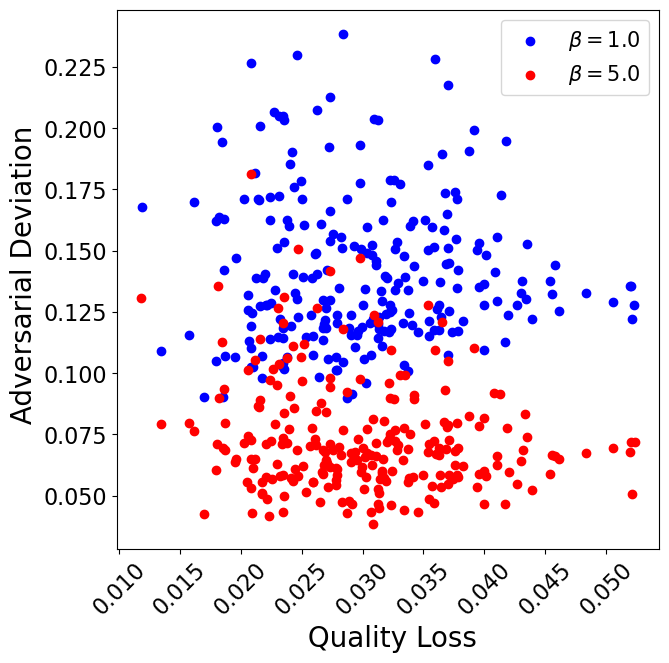

In [54]:
plt.figure(figsize=(7, 7))  # Adjust the width and height as needed

plt.scatter(beta1_recon_loss, beta1_deviations, color='blue', label=r"$\beta = 1.0$")
plt.scatter(beta2_recon_loss, beta2_deviations, color='red', label=r"$\beta = 5.0$")
#plt.scatter(beta3_recon_loss, beta2_deviations, color='green', label=r"$\beta = 10.0$")

plt.ylabel(" Adversarial Deviation", fontsize=20)  # Using LaTeX formatting for the ylabel

plt.xlabel(" Quality Loss", fontsize=20)  # Using LaTeX formatting for the ylabel
plt.xticks(fontsize=16, rotation=45)  # Adjust the fontsize as needed
plt.yticks(fontsize=16)  # Adjust the fontsize as needed

plt.legend(fontsize=15)